In [ ]:
# Import libraries
import pandas as pd

# Load multiple CSV files and combine them
file_paths = ["/tweets-extra.csv", "/tweets-train.csv", "/tweets-valid.csv"]  # Add all your CSV paths here
dataframes = [pd.read_csv(file, encoding="utf-8") for file in file_paths]

# Concatenate all dataframes
df = pd.concat(dataframes, ignore_index=True)

# Display the first 5 rows to verify the data
df.head()


,tweet,label
0,लोकसभा निवडणूक २०१९ मध्ये @NCPspeaks चे निष्...,1
1,कोकण एज्युकेशन सोसायटीच्या पनवेल येथील विठोब...,1
2,जुने पारगांव ता. हातकंणगले येथे बिरदेव मंदिर...,1
3,आज महापराक्रमी छत्रपती संभाजी महाराज यांच्या...,1
4,जनता-जनार्दन हेच आमचे दैवत!\nआणि या दैवताच्य...,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16128 entries, 0 to 16127
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweet   16128 non-null  object
 1   label   16128 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 252.1+ KB
None
              label
count  16128.000000
mean       0.136161
std        0.836738
min       -1.000000
25%       -1.000000
50%        0.000000
75%        1.000000
max        1.000000


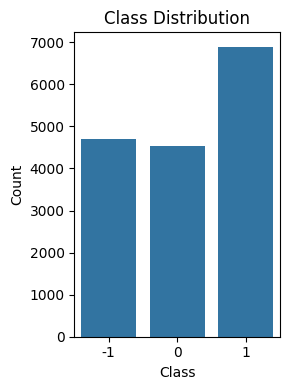

tweet    0
label    0
dtype: int64


In [ ]:
#step 2:EDA
import matplotlib.pyplot as plt
import seaborn as sns

# Check dataset info
print(df.info())
print(df.describe())

# Set smaller figure size (e.g., width=5, height=4)
plt.figure(figsize=(3, 4))  # Adjust dimensions as needed
sns.countplot(x='label', data=df)  # Update 'label' with your target column name
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.tight_layout()  # Prevents label cutoff
plt.show()

# Check for missing values
print(df.isnull().sum())



In [ ]:
#STEP 3 : PREPROCESSING
import re
import nltk
import pandas as pd
nltk.download('punkt')

# Define custom Marathi stopwords
marathi_stopwords = set([
    "आहे", "नाही", "आणि", "हे", "तुम्ही", "मी", "तो", "ती", "त्याचे", "त्याची", "आम्ही",
    "किंवा", "मध्ये", "यामुळे", "म्हणून", "कसे", "ते", "जे", "तर", "हा", "हि", "या", "याने",
    "पण", "त्याला", "त्यामुळे", "त्यांनी", "कोण", "का", "कधी", "कुठे"
])

# Text cleaning function
def clean_text(text):
    if pd.isnull(text):
        return "MISSING_TEXT"

    text = str(text).lower()  # Lowercase
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)  # Remove URLs
    text = re.sub(r"[!\"#$%&'()*+,./:;<=>?@[\]^_`{|}~]", "", text)  # Remove punctuation
    text = re.sub(r"\d+", "", text)  # Remove numbers
    text = " ".join([word for word in text.split() if word not in marathi_stopwords])  # Remove stopwords
    return text

# Apply text cleaning
# The DataFrame might have a column named 'tweet' instead of 'text'
# Change 'text' to 'tweet' to access the correct column
df["cleaned_text"] = df["tweet"].apply(clean_text)  # Update 'text' to your column name

# Display cleaned data
df[['tweet', 'cleaned_text']].head() # Also change 'text' to 'tweet' here

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,tweet,cleaned_text
0,लोकसभा निवडणूक २०१९ मध्ये @NCPspeaks चे निष्...,लोकसभा निवडणूक ncpspeaks चे निष्ठावान नेते माझ...
1,कोकण एज्युकेशन सोसायटीच्या पनवेल येथील विठोब...,कोकण एज्युकेशन सोसायटीच्या पनवेल येथील विठोबा ...
2,जुने पारगांव ता. हातकंणगले येथे बिरदेव मंदिर...,जुने पारगांव ता हातकंणगले येथे बिरदेव मंदिरास ...
3,आज महापराक्रमी छत्रपती संभाजी महाराज यांच्या...,आज महापराक्रमी छत्रपती संभाजी महाराज यांच्या ज...
4,जनता-जनार्दन हेच आमचे दैवत!\nआणि या दैवताच्य...,जनता-जनार्दन हेच आमचे दैवत दैवताच्या दर्शनासाठ...


In [ ]:
import numpy as np

# Generate NLP features
def generate_nlp_features(df):
    # Character count
    df['char_count'] = df['cleaned_text'].apply(len)
    # Word count
    df['word_count'] = df['cleaned_text'].apply(lambda x: len(x.split()))
    # Average word length
    df['avg_word_length'] = df['cleaned_text'].apply(lambda x: np.mean([len(word) for word in x.split()]) if x.split() else 0)
    # Stopword count
    df['stopword_count'] = df['cleaned_text'].apply(lambda x: len([word for word in x.split() if word in stop_words]))
    # Hashtag count (if applicable)
    df['htag_count'] = df['cleaned_text'].apply(lambda x: x.count('#'))

    return df

# Generate features
df = generate_nlp_features(df)
df[['char_count', 'word_count', 'avg_word_length', 'stopword_count', 'htag_count']].head()


,char_count,word_count,avg_word_length,stopword_count,htag_count
0,209,25,7.400000,0,0
1,288,35,7.257143,0,0
2,102,15,5.866667,0,0
3,281,28,9.071429,0,0
4,132,14,8.500000,0,0


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Bag of Words (BoW)
bow_vectorizer = CountVectorizer(max_features=5000)
X_bow = bow_vectorizer.fit_transform(df['cleaned_text'])

# TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(df['cleaned_text'])

# Combine NLP features with TF-IDF for combined feature set
from scipy.sparse import hstack
X_combined = hstack([X_tfidf, df[['char_count', 'word_count', 'avg_word_length', 'stopword_count', 'htag_count']].values])
